In [1]:
import os  # way interact with the os
import itertools # each tools
import cv2 # library for computer vision tasks
# import data handling tools

import numpy as np # for array,matrics, high performance
import pandas as pd #data manuplation,analysis
import seaborn as sns #built on matplotlib,it provides high level visualization capabilities
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

     # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [4]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's keys (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [5]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 1843 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


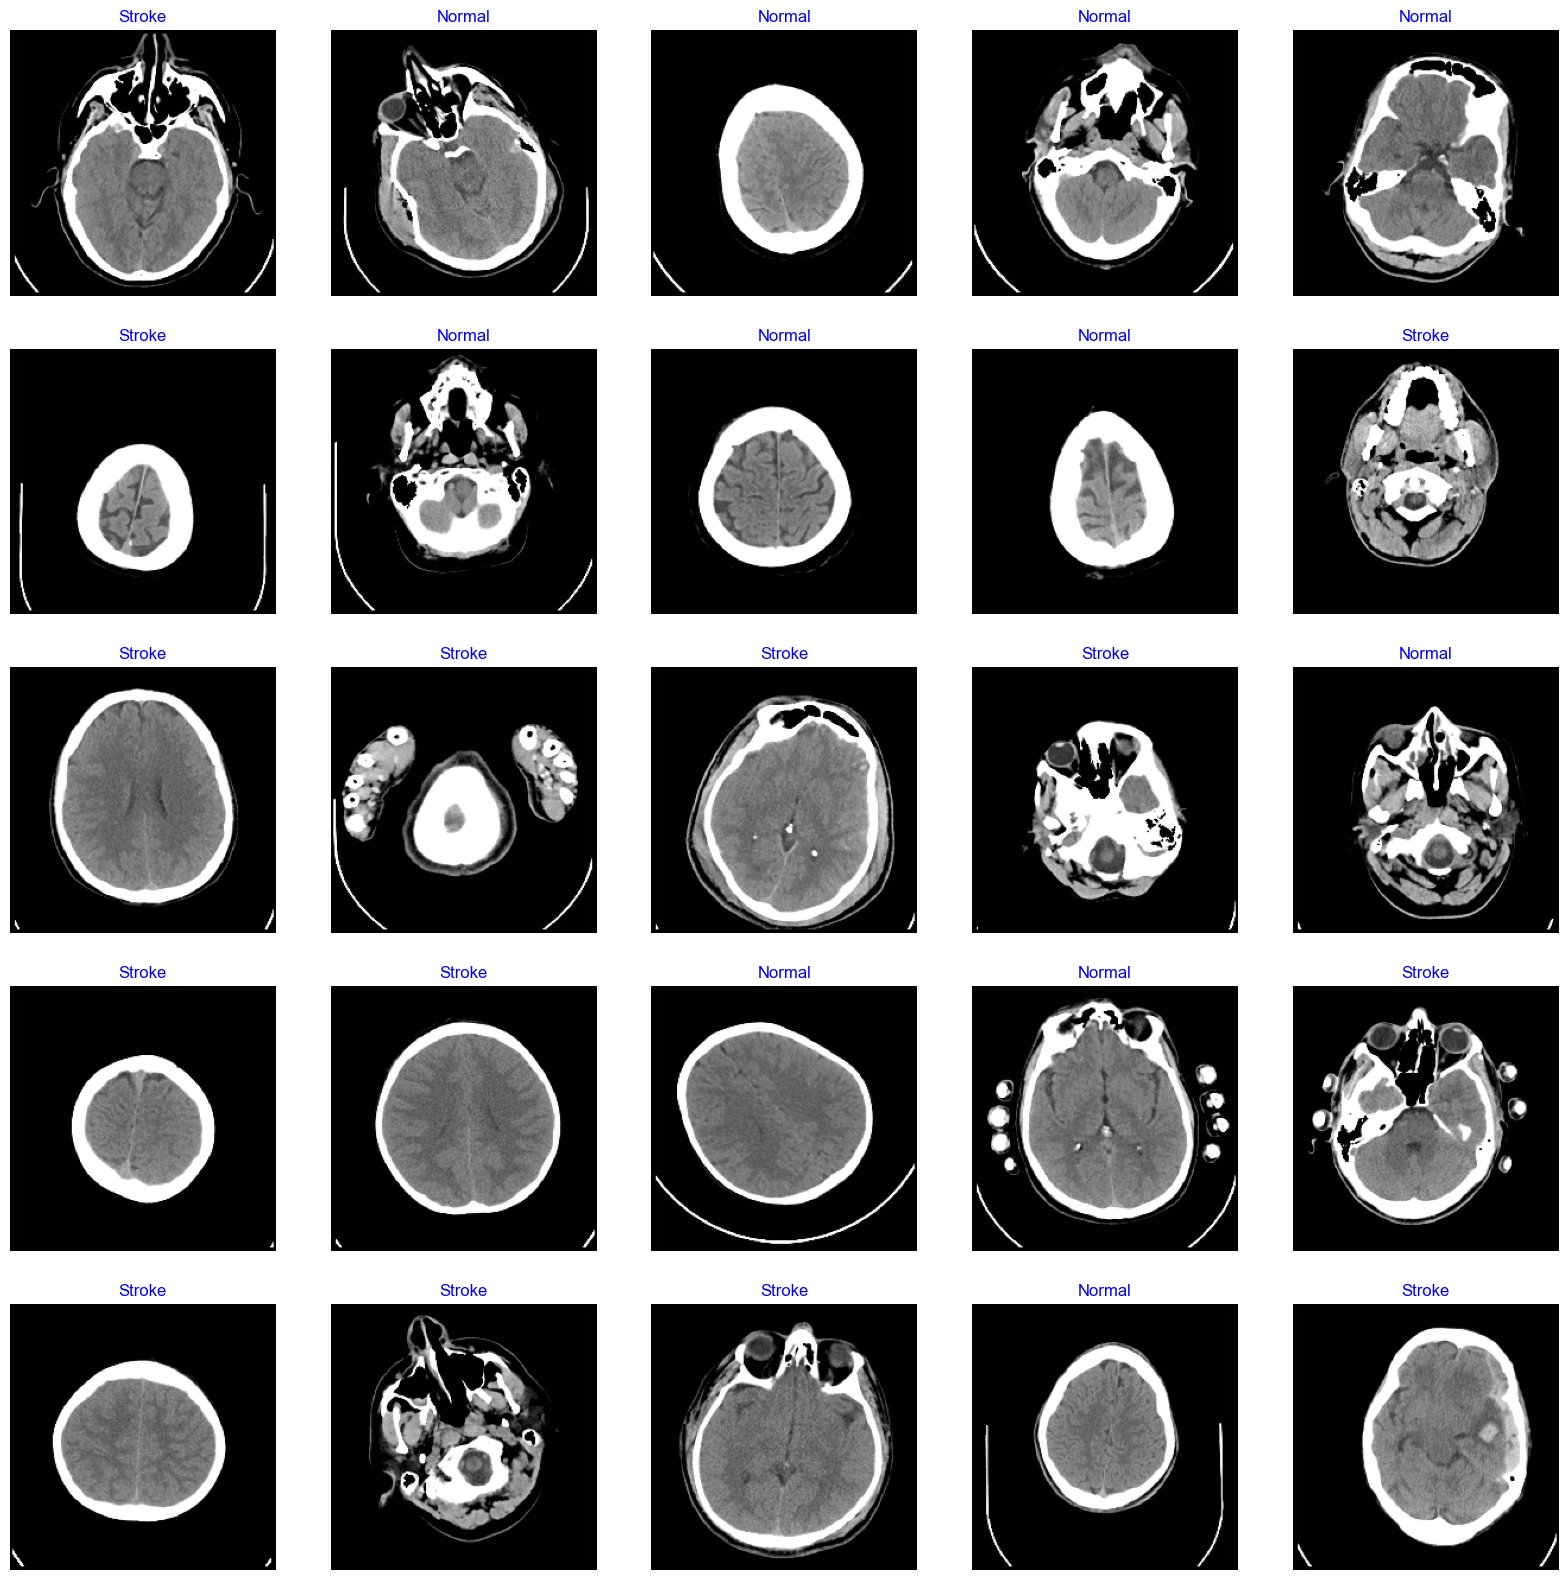

In [7]:
# Get Dataframes
train_dir = r'C:/Users/Meghana/PycharmProjects/FlaskProject/Brain_Stroke_CT-SCAN_image/Train'
valid_dir = r'C:/Users/Meghana/PycharmProjects/FlaskProject/Brain_Stroke_CT-SCAN_image/Validation'
test_dir = r'C:/Users/Meghana/PycharmProjects/FlaskProject/Brain_Stroke_CT-SCAN_image/Test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([ Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape), Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"), MaxPooling2D((2, 2)),

Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
MaxPooling2D((2, 2)),

Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
MaxPooling2D((2, 2)),

Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
MaxPooling2D((2, 2)),

Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
MaxPooling2D((2, 2)),
Flatten(),
Dense(256,activation = "relu"),
Dense(64,activation = "relu"),
Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,050 (80.70 MB)

 Trainable params: 21,154,050 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x= train_gen, epochs=25, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False, initial_epoch= 0)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 817s 17s/step - accuracy: 0.5697 - loss: 212.8568 - val_accuracy: 0.6681 - val_loss: 0.6569
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 777s 16s/step - accuracy: 0.5902 - loss: 0.6780 - val_accuracy: 0.6681 - val_loss: 0.6763
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 807s 17s/step - accuracy: 0.5927 - loss: 0.6819 - val_accuracy: 0.6681 - val_loss: 0.6322
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 827s 18s/step - accuracy: 0.5818 - loss: 0.6779 - val_accuracy: 0.6383 - val_loss: 0.6190
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 903s 19s/step - accuracy: 0.6061 - loss: 0.6566 - val_accuracy: 0.7021 - val_loss: 0.5601
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 950s 20s/step - accuracy: 0.6684 - loss: 0.5912 - val_accuracy: 0.6468 - val_loss: 0.6259
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 774s 16s/step - accuracy: 0.7326 - loss: 0.5150 - val_accuracy: 0.6170 - val_loss: 0.6140
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 776s 17s/step - accuracy: 0.7346 - loss: 0.5130 - val_accuracy: 

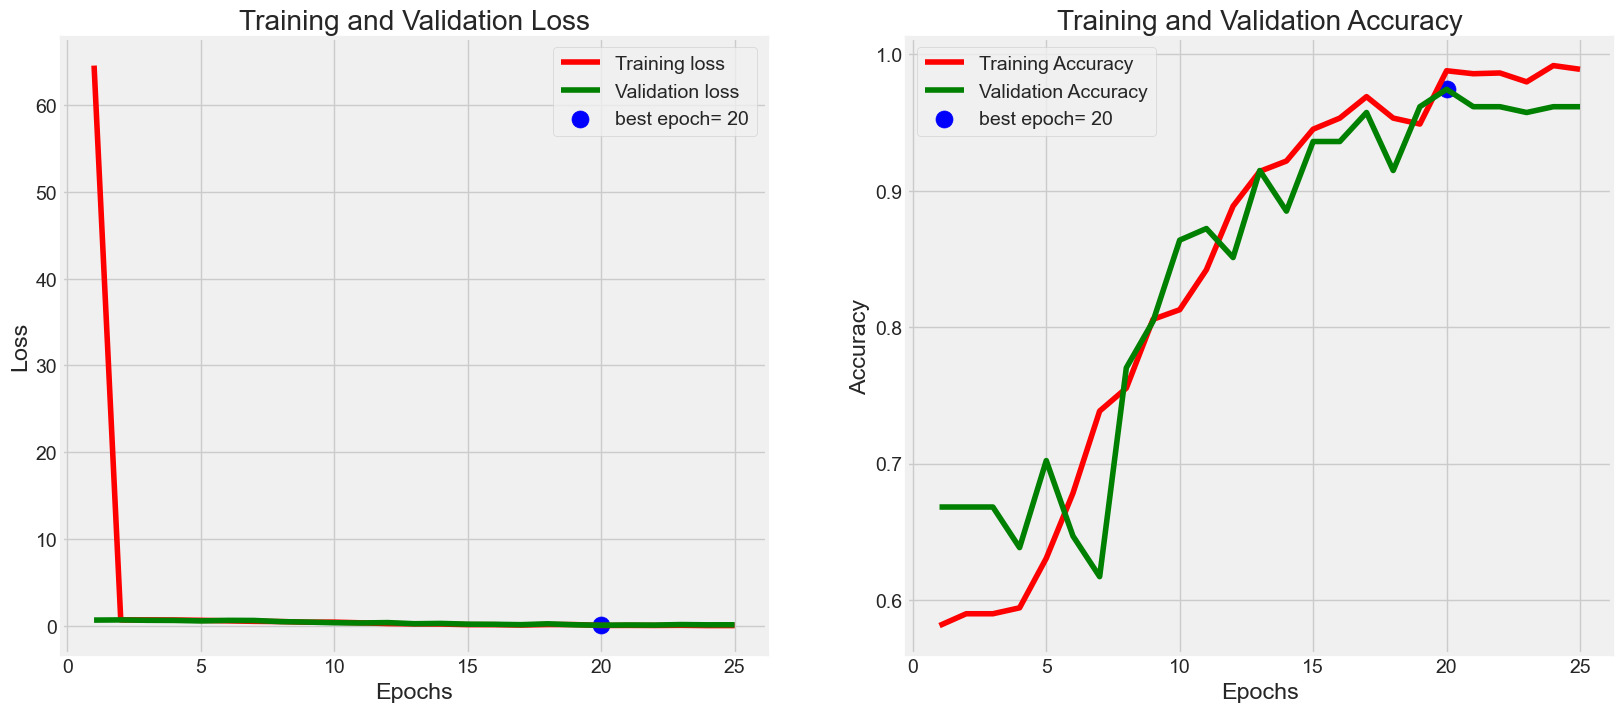

In [10]:
plot_training(history)

In [11]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.9816 - loss: 0.0405
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 908ms/step - accuracy: 0.9639 - loss: 0.1083
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9920 - loss: 0.0210
Train Loss:  0.03572673350572586
Train Accuracy:  0.9842105507850647
--------------------
Validation Loss:  0.1169174537062645
Validation Accuracy:  0.9617021083831787
--------------------
Test Loss:  0.050545670092105865
Test Accuracy:  0.9816933870315552


In [16]:
# Predict on the test data
preds = model.predict(test_gen)  # Use `predict` instead of `predict_generator`
# Get the indices of the maximum prediction probabilities
y_pred = np.argmax(preds, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


Confusion Matrix, Without Normalization
[[306   1]
 [  7 123]]
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       307
      Stroke       0.99      0.95      0.97       130

    accuracy                           0.98       437
   macro avg       0.98      0.97      0.98       437
weighted avg       0.98      0.98      0.98       437



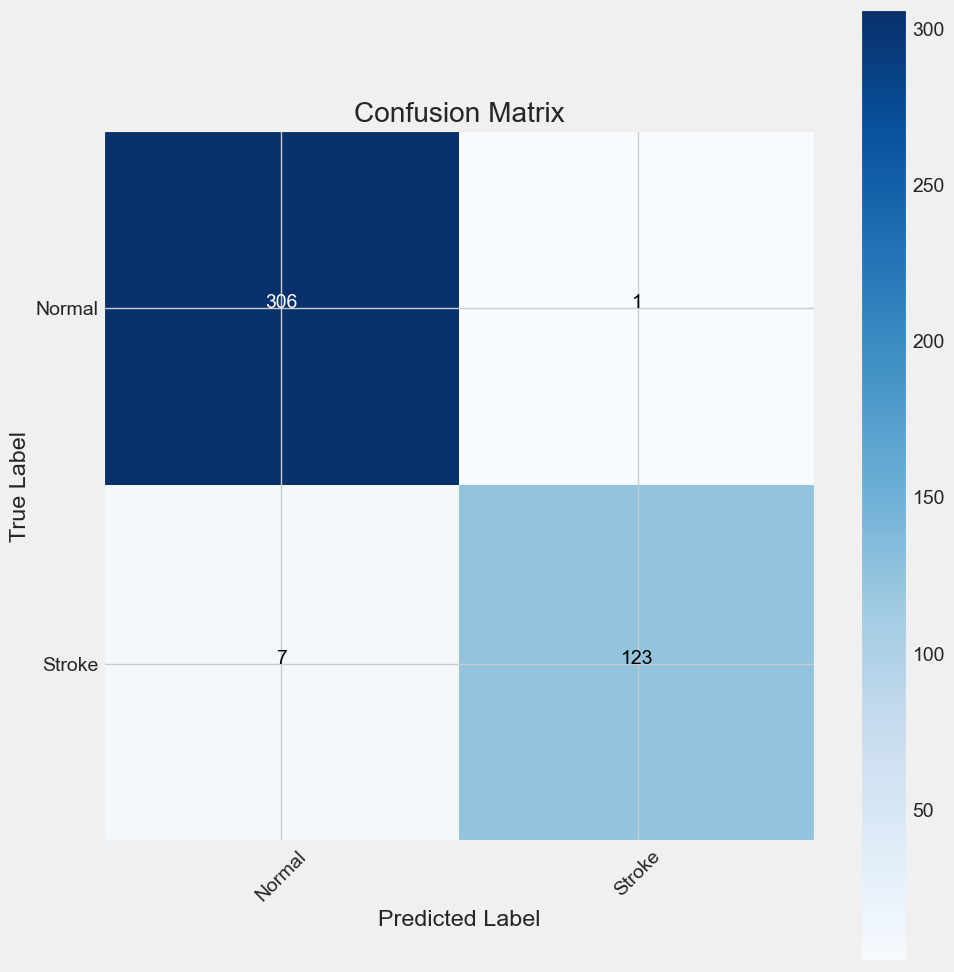

In [17]:
target_names = ['Normal', 'Stroke']

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))